# Create media designs using Latin Hypercube for LCMS flaviolin experiment

This notebook generates a set of media designs using Latin Hypercube sampling. We use ART's capability to provide this kind of designs for media components for which to get phenotypic data. We will use two types of assays for this experiment - absorbance at 340nm and LCMS measurements.  


We include a design that is very close to the standard media (up to 5% variation for each component), as a control for every cycle.

Tested using **ART 3.9.4** kernel on jprime.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds.csv`
- `standard_recipe_concentrations.csv`

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')
import re
import warnings
 
import matplotlib.pyplot as plt

from art.core import * 
import art.plot as plot
import edd_utils as eddu
# from core import designs_pairwise


## User parameters

### Defining media components and the number of instances (designs) to be created

In [2]:
CYCLE = 6

user_params = {
    'bounds_file': f'../data/flaviolin/Putida_media_bounds.csv',
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/flaviolin/standard_recipe_concentrations.csv',
}

Specify which components to explore:

In [3]:
user_params['components'] = [
    'H3BO3',
    'K2SO4',
    'K2HPO4',
    'FeSO4',
    'NH4Cl',
    'MgCl2',
    'NaCl',
    '(NH4)6Mo7O24',
    'CoCl2',
    'CuSO4',
    'MnSO4',
    'ZnSO4'
]

Here we specify how many instances (designs) we want to create and how many replicates (change as desired). In this case we run two DBTL cycles with initial designs, 12 instances with 4 replicates for each, out of which one design is reserved for the control.

In [4]:
user_params['n_instances'] = 15
user_params['n_replicates'] = 3 

In [5]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [6]:
df_stand

,Concentration[mM],Solubility[mM]
Component,,
MOPS,40.00000,2389.37
Tricine,4.00000,500.08
H3BO3,0.00400,700.00
Glucose,20.00000,5045.63
K2SO4,0.29000,636.98
K2HPO4,1.32000,8564.84
FeSO4,0.01000,1645.73
NH4Cl,9.52000,6543.28
MgCl2,0.52000,569.27


### Generate the control media 

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [7]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at[0, component] = stand_conc*np.random.uniform(lb, ub)


In [11]:
df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.003968,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103


In [8]:
df_control.loc[0] = np.array(
    [0.003968, 
     0.278836,
     1.196387,
     0.010759,
     10.408408,
     0.475231,
     51.20097,
     0.000028,
     0.000316,
     0.000091,
     0.000777,
     0.000103]
)

### Generate random media

Define a dictionary that contains the settings that ART will use to find the recommended designs:

In [9]:
art_params = {
    'input_vars': user_params['components'],  # input variables, i.e. features
    'bounds_file': user_params['bounds_file'],  # file with bounds
    'num_recommendations': user_params['n_instances'],   
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': 10,                                               # seed for number random generator
    'output_directory': user_params['output_file_path']  # directory to store this output
}


With the configuration stored in `art_params`, we now run ART:

In [10]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.tail()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
10,0.011667,2.882740,0.995188,0.090655,10.324943,1.933593,189.206250,0.000157,0.000048,0.000507,0.002133,0.000588
11,0.021833,0.405193,0.424550,0.045675,7.721296,3.019698,136.129853,0.000142,0.002977,0.000726,0.006938,0.000415
12,0.007477,1.365148,3.268669,0.097711,10.965631,0.771413,391.274625,0.000066,0.001611,0.000809,0.006266,0.000899
13,0.034219,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
14,0.002513,0.691736,2.092997,0.061301,9.694639,1.242139,147.653638,0.000061,0.000376,0.000416,0.003509,0.000269


In [11]:
df_target = df.copy()
df_target = df_target.append(df_control).reset_index(drop=True)
df_target

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
3,0.039421,2.139989,6.48219,0.004907,8.404625,1.63091,409.900003,0.000029,0.000997,0.000322,0.000492,0.0003
4,0.003822,2.110887,4.828971,0.054005,12.426865,3.494197,309.231334,0.000193,0.001809,0.00002,0.004225,0.00049
5,0.019247,0.063172,5.616681,0.071373,8.774074,0.114856,486.966008,0.000276,0.002404,0.000233,0.00758,0.000716
6,0.014314,1.389174,3.018874,0.03269,11.53211,3.145739,66.174686,0.000219,0.00109,0.000193,0.007039,0.000647
7,0.03157,1.171567,2.755917,0.039552,12.915469,0.694204,347.206468,0.000167,0.002186,0.000782,0.003175,0.000109
8,0.03717,2.57281,1.415232,0.026265,14.070721,4.071614,286.626122,0.000286,0.000589,0.000105,0.00532,0.000975
9,0.027296,1.86347,1.870718,0.051378,12.142509,4.286369,441.442899,0.000005,0.002629,0.000664,0.005428,0.000175


### Checking the distribution of initial designs

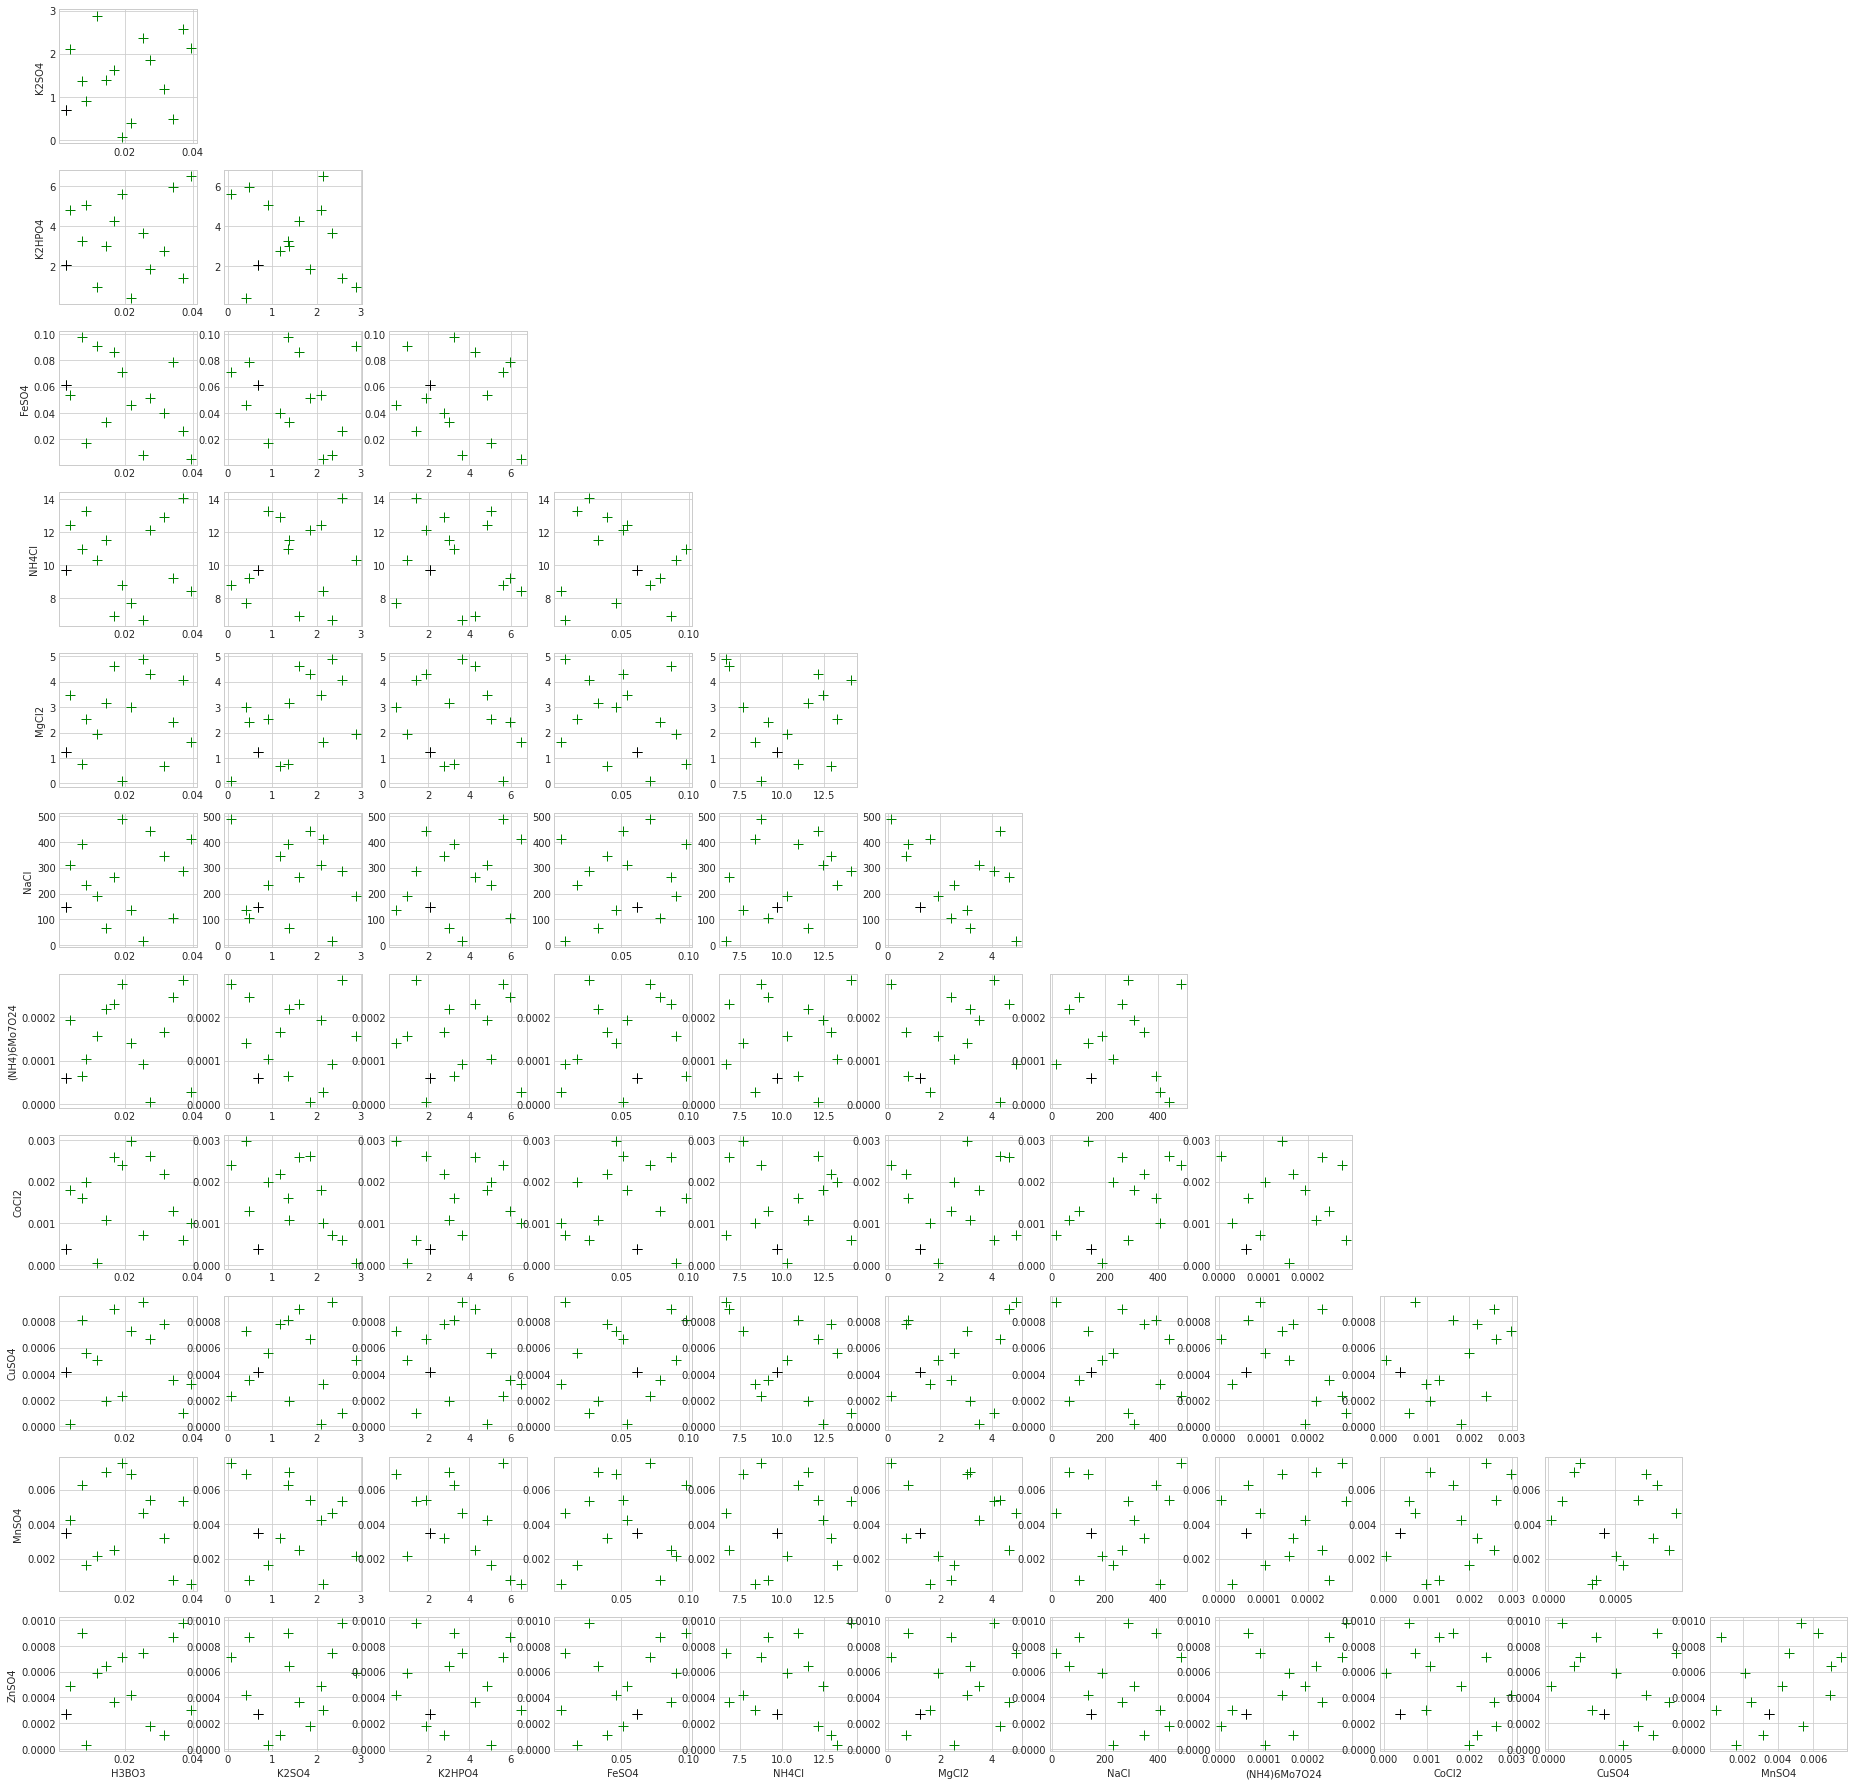

In [12]:
designs_pairwise(art, df, user_params, initial=True)

## Saving the generated designs

Include all replicates: 

In [13]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [14]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [15]:
well_names = [f'{row}{column}' for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
Well,,,,,,,,,,,,
A1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
B1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
C1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.00095,0.004621,0.000744
D1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
E1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
F1,0.008628,0.896852,5.044414,0.017022,13.269195,2.52172,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
A2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
B2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
C2,0.01668,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363


In [16]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target.to_csv(file)

In [35]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target = pd.read_csv(file)

In [36]:
df_target

,Well,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,A1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744
1,B1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744
2,C1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744
3,D1,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
4,E1,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
5,F1,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029
6,A2,0.016680,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
7,B2,0.016680,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
8,C2,0.016680,1.612222,4.255821,0.086456,6.883767,4.633128,263.493369,0.000231,0.002586,0.000896,0.002504,0.000363
9,D2,0.039421,2.139989,6.482190,0.004907,8.404625,1.630910,409.900003,0.000029,0.000997,0.000322,0.000492,0.000300


## Train ART on all previous data (DBTL 1-5)

In [10]:
user_params['study_slug_1'] = 'combinatorial-media-for-flaviolin-dbtl1-ed1e'
user_params['study_slug_2'] = 'combinatorial-media-for-flaviolin-dbtl-2'
user_params['study_slug_3'] = 'combinatorial-media-for-flaviolin-dbtl-3'
user_params['study_slug_4'] = 'combinatorial-media-for-flaviolin-dbtl-4'
user_params['study_slug_5'] = 'combinatorial-media-for-flaviolin-dbtl-5'

user_params['edd_server'] = 'edd.jbei.org'
user_params['username'] = 'tradivojevic'

user_params['response'] = 'OD340'

## Load the data

In [11]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']
edd_server = user_params['edd_server']
username = user_params['username']

In [13]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [14]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Concatenate the three studies:

In [15]:
df = df_1.append(df_2).append(df_3).append(df_4).append(df_5)

Drop unnecessary columns:

In [16]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


Pivot the dataframe to include columns for all protocols:

In [17]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Protocol", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


### Adding media information to the data frame

Add columns for each component:

In [18]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None


And assign values for each component and line:

In [19]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
235,C5_WD7_F7-R2,0.6091,0.708,40.0,4.0,0.037489,20.0,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037
236,C5_WD7_F7-R3,0.6303,0.445,40.0,4.0,0.037489,20.0,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037
237,C5_WD8_F8-R1,0.2476,1.469,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109
238,C5_WD8_F8-R2,0.2498,1.283,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109
239,C5_WD8_F8-R3,0.2316,0.863,40.0,4.0,0.004112,20.0,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109


Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In DBTL 3 is stored in the last column (D8, E8, F8).

In [20]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

In [21]:
control_lines

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
44,C1_WF5_F8-R1,0.2856,0.731,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
45,C1_WF5_F8-R2,0.2936,0.763,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
46,C1_WF5_F8-R3,0.2715,0.664,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
47,C1_WF5_F8-R4,0.2891,0.795,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102
92,C2_WF5_F8-R1,0.2934,0.631,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
93,C2_WF5_F8-R2,0.2912,0.593,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
94,C2_WF5_F8-R3,0.3004,0.601,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
95,C2_WF5_F8-R4,0.2990,0.671,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
141,C3_WD8_F8-R1,0.2813,1.022,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098
142,C3_WD8_F8-R2,0.2755,0.800,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098


How many designs improve response over the standard recipe?

In [22]:
control_response = np.max(control_lines['OD340'])
num_improved_response = np.sum(df['OD340'] > control_response)
num_designs = len(df) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of OD340 ({num_improved_response/num_designs*100:.2f}%).')


184 samples out of 223 improve over the standard in terms of OD340 (82.51%).


### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [23]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS,40.0
3,C1_WA1_A4-R1,Tricine,4.0
4,C1_WA1_A4-R1,H3BO3,0.003744


### ART training

Define a dictionary that contains the settings that ART will use to generate a predictive model:

In [24]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds# input variables, i.e. features
    'seed': 10,                                           # seed for number random generator
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],  # directory to store this output
    'verbose': 1,
    'max_mcmc_cores': 2
}

With the configuration stored in art_params, we now run ART:

In [25]:
run_art = True

Using a maximum of 2 cores for MCMC sampling (of 4 available).
Best pipeline: XGBRegressor(VarianceThreshold(VarianceThreshold(input_matrix, threshold=0.001), threshold=0.001), learning_rate=0.1, max_depth=7, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.4, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 59 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 1984.93 s
Best pipeline: XGBRegressor(ZeroCount(DecisionTreeRegressor(ZeroCount(StandardScaler(input_matrix)), max_depth=7, min_samples_leaf=14, min_samples_split=12)), learning_rate=0.1, max_depth=5, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 94 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 102.90 s
Best pipeline: RandomForestRegressor(MinMaxScaler(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.45, min_samples_leaf=17, min_samples_split=10, n_estimators=100)), bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=7, min_samples_split=17, n_estimators=100)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 80 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Done building ensemble model in 87.96 s
Best pipeline: XGBRegressor(LinearSVR(VarianceThreshold(input_matrix, threshold=0.2), C=25.0, dual=True, epsilon=0.001, loss=epsilon_insensitive, tol=0.0001), learning_rate=0.1, max_depth=6, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.5, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 87 seconds.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 97.60 s
Best pipeline: XGBRegressor(GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.01, loss=lad, max_depth=2, max_features=0.15000000000000002, min_samples_leaf=11, min_samples_split=2, n_estimators=100, subsample=0.2), learning_rate=0.1, max_depth=9, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.5, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 132 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 139.79 s
Best pipeline: XGBRegressor(ElasticNetCV(VarianceThreshold(input_matrix, threshold=0.005), l1_ratio=0.35000000000000003, tol=1e-05), learning_rate=0.1, max_depth=3, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 114 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 122.56 s
Best pipeline: RidgeCV(XGBRegressor(MinMaxScaler(LassoLarsCV(VarianceThreshold(input_matrix, threshold=0.05), normalize=False)), learning_rate=0.1, max_depth=9, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9500000000000001, verbosity=0))
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 72 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 475 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Done building ensemble model in 80.97 s
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=12, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.45, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 85 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Done building ensemble model in 94.81 s
Best pipeline: XGBRegressor(CombineDFs(SelectFromModel(input_matrix, max_features=0.4, n_estimators=100, threshold=0.2), input_matrix), learning_rate=0.1, max_depth=3, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.45, verbosity=0)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 75 seconds.
There were 1164 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 84.01 s
Best pipeline: LinearSVR(RidgeCV(VarianceThreshold(RidgeCV(input_matrix), threshold=0.0001)), C=5.0, dual=True, epsilon=0.1, loss=epsilon_insensitive, tol=0.0001)
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 121 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6742595085394691, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Done building ensemble model in 130.33 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.127998,34.945721,0.100736,0.026531,-0.275900
Random Forest Regressor,0.059321,15.595611,0.046969,0.005725,0.724679
TPOT Regressor,0.057853,14.989222,0.047273,0.005582,0.731572
Support Vector Regressor,0.078425,22.246586,0.052853,0.008944,0.569878
Kernel Ridge Regressor,0.102384,23.781388,0.080540,0.016969,0.183942
K-NN Regressor,0.070306,19.494099,0.063654,0.008995,0.567432
Gaussian Process Regressor,0.065648,18.326115,0.057744,0.007644,0.632400
Gradient Boosting Regressor,0.055387,14.701669,0.043560,0.004965,0.761223
Ensemble Model,0.056356,14.940230,0.046834,0.005369,0.741782


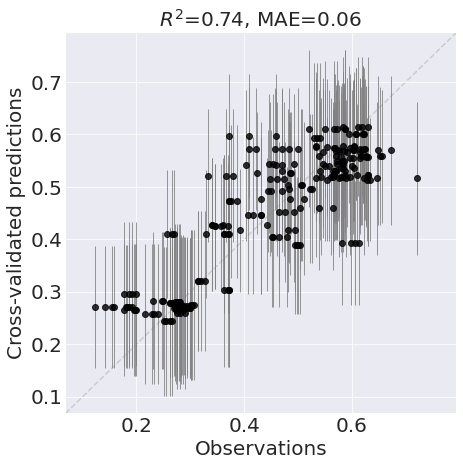

Best pipeline: RidgeCV(XGBRegressor(DecisionTreeRegressor(RobustScaler(input_matrix), max_depth=10, min_samples_leaf=15, min_samples_split=11), learning_rate=0.1, max_depth=6, min_child_weight=13, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.35000000000000003, verbosity=0))
Building ensemble model…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 97 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 106.38 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.071531,17.170401,0.057581,0.008432,0.594488
Random Forest Regressor,0.014496,3.302913,0.014225,0.000412,0.980163
TPOT Regressor,0.017736,4.312272,0.016040,0.000572,0.972500
Support Vector Regressor,0.060299,16.022328,0.031117,0.004604,0.778582
Kernel Ridge Regressor,0.026860,6.201236,0.023790,0.001287,0.938086
K-NN Regressor,0.025754,6.427141,0.023811,0.001230,0.940836
Gaussian Process Regressor,0.014957,3.479483,0.014082,0.000422,0.979705
Gradient Boosting Regressor,0.014689,3.358970,0.014157,0.000416,0.979985
Ensemble Model,0.016605,3.980830,0.015536,0.000517,0.975132


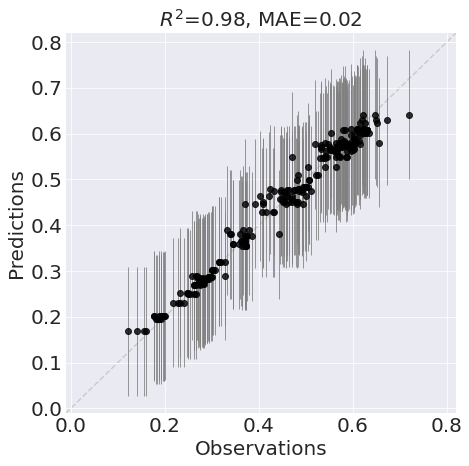

CPU times: user 1h 39min 22s, sys: 7min 29s, total: 1h 46min 52s
Wall time: 2h 22min 51s


In [26]:
%%time
warnings.filterwarnings("ignore")
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

In [27]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.127998,34.945721,0.100736,0.026531,-0.275900
Random Forest Regressor,0.059321,15.595611,0.046969,0.005725,0.724679
TPOT Regressor,0.057853,14.989222,0.047273,0.005582,0.731572
Support Vector Regressor,0.078425,22.246586,0.052853,0.008944,0.569878
Kernel Ridge Regressor,0.102384,23.781388,0.080540,0.016969,0.183942
K-NN Regressor,0.070306,19.494099,0.063654,0.008995,0.567432
Gaussian Process Regressor,0.065648,18.326115,0.057744,0.007644,0.632400
Gradient Boosting Regressor,0.055387,14.701669,0.043560,0.004965,0.761223
Ensemble Model,0.056356,14.940230,0.046834,0.005369,0.741782


Generate ART predictions for the suggested designs:

In [39]:
target_predicted_mean, target_predicted_std = art.post_pred_stats(
            df_target[user_params['components']]
        )


In [40]:
df_target['OD340_pred'] = target_predicted_mean
df_target['OD340_std'] = target_predicted_std
df_target['Label'] = 'LHS'

In [41]:
df_target.head()

,Well,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
0,A1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744,0.283067,0.072042,LHS
1,B1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744,0.283067,0.072042,LHS
2,C1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744,0.283067,0.072042,LHS
3,D1,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029,0.440755,0.071896,LHS
4,E1,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029,0.440755,0.071896,LHS


In [42]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target.to_csv(file)

Define dataframe with train data and predictions:

In [28]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']

Add predictions, cv-predictions and standard deviation of the OD340 predictions:

In [29]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [30]:
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [31]:
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [32]:
df_train

Protocol,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.380489,0.071881,0.427714,0.064774,train
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.380489,0.071881,0.427714,0.064774,train
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.380489,0.071881,0.427714,0.064774,train
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.380489,0.071881,0.427714,0.064774,train
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0.2699,0.272370,0.071882,0.270149,0.066677,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.037489,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037,0.6091,0.607873,0.071971,0.523268,0.068902,train
236,0.037489,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.00028,0.002575,0.000967,0.004346,0.000037,0.6303,0.607873,0.071971,0.523268,0.068902,train
237,0.004112,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109,0.2476,0.252438,0.071824,0.283199,0.066534,standard
238,0.004112,0.261299,1.194531,0.01038,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109,0.2498,0.252438,0.071824,0.283199,0.066534,standard


Save train data set for this cycle:

In [43]:
file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)